# Analysis and First Model

In [1]:
# General imports and notebook settings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

%matplotlib inline
plt.rcParams['figure.figsize'] = [8, 8]

First, we read the cleaned data into a data frame.

In [2]:
with open('./data/google_sentiments.json', 'r') as infile:
    data = pd.read_json(infile, orient = 'records')
data.head()

,google_mag,google_score,id,price,rating,rec_dishes,review_text,review_url
0,22.0,0.1,2,4,1,8,My dinner date had eaten in this room before....,https://www.nytimes.com/2014/04/02/dining/rest...
1,21.5,0.1,3,4,2,11,You can put up with mediocre food in a restau...,https://www.nytimes.com/2013/11/20/dining/revi...
2,26.0,0.1,4,3,3,7,A few minutes into my first dinner at Bâtard ...,https://www.nytimes.com/2014/08/27/dining/rest...
3,22.4,0.1,5,4,1,6,"After a long and grueling winter, nothing lif...",https://www.nytimes.com/2015/04/08/dining/rest...
4,24.0,-0.1,6,4,Satisfactory,4,"By the early 1980s, New Yorkers knew that som...",https://www.nytimes.com/2015/11/11/dining/jams...


In [3]:
data.shape

(245, 8)

## Exploratory Analysis

Our hypothesis is that Wells gives the two-star rating too often.  So first, how often does he actually give two star ratings?

In [5]:
rating_counts = data.groupby('rating').size()
rating_counts

rating
1                72
2               124
3                34
4                 3
Fair              4
Satisfactory      8
dtype: int64

In [6]:
rating_counts/sum(rating_counts)

rating
1               0.293878
2               0.506122
3               0.138776
4               0.012245
Fair            0.016327
Satisfactory    0.032653
dtype: float64

A little more than half the time.  We can ask similar questions for the other variables:

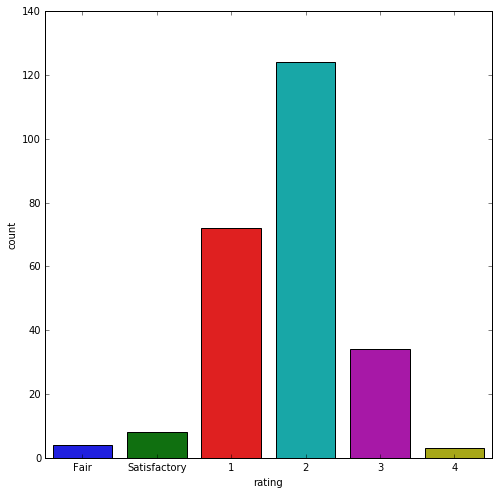

In [8]:
ratings_order = ["Fair", "Satisfactory","1", "2", "3", "4"]
sns.countplot(x = 'rating', data = data, order = ratings_order)

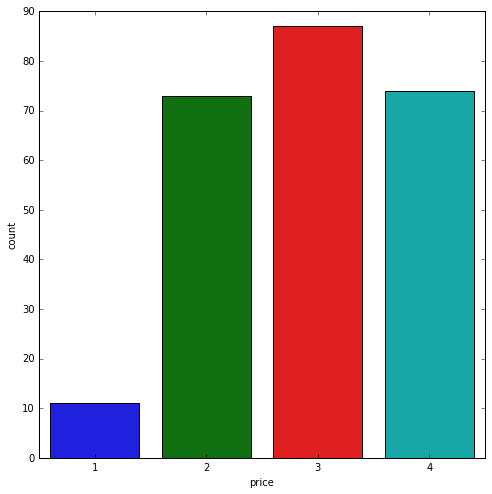

In [9]:
sns.countplot(x = 'price', data = data)

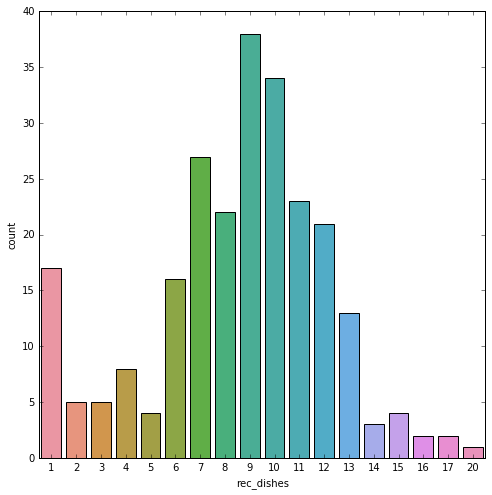

In [10]:
sns.countplot(x = 'rec_dishes', data = data)

Note that the peak at 1 is likely due to the fact that restaurants that serve only a tasting menu will not have any recommended dishes, and our current method for counting recommended dishes (counting the number of items in the list of recommended dishes) counts that as one recommended item. This is something to try to address in the future.

The main goal is to try to predict ratings based on the review text via the sentiment score. Let's see how that compares.

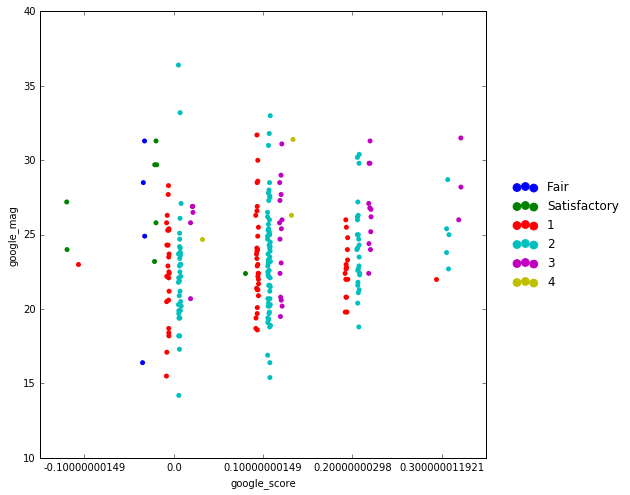

In [11]:
sns.stripplot(x="google_score", y="google_mag", data=data,
                hue="rating", dodge = True, hue_order = ratings_order)
plt.legend(bbox_to_anchor=(1.05, 0.5), loc=6, borderaxespad=0., frameon = False)

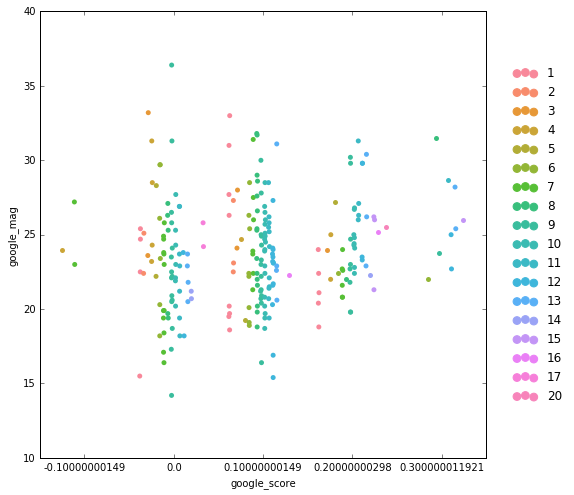

In [12]:
sns.stripplot(x="google_score", y="google_mag", dodge = True, hue = "rec_dishes", data=data)
plt.legend(bbox_to_anchor=(1.05, 0.5), loc=6, borderaxespad=0., frameon = False)

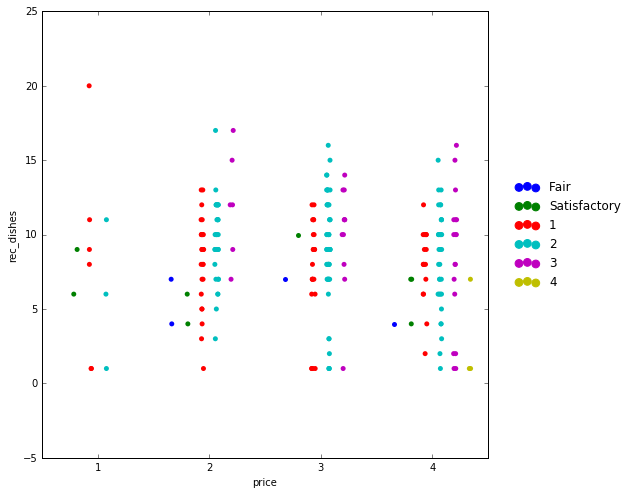

In [13]:
sns.stripplot(x="price", y="rec_dishes", data=data, 
              hue = "rating",dodge = True, hue_order = ratings_order)
plt.legend(bbox_to_anchor=(1.05, 0.5), loc=6, borderaxespad=0., frameon = False)

There's not really any obvious correlations. The final plot shows that 3 and 4 star restaurants are more likely to be very expensive (no big surprise), but otherwise there are no obvious patterns.

### Building a model

Still, we'll try to build a model from this data that will predict the star rating from the remaining features of the data set - perhaps the model will be able to find some pattern in the data that's not obvious in the graphs above.  

We'll extract the features from the data, and then split into training and testing sets, using the default of 80% as the training data.

In [14]:
X = data[['google_mag', 'google_score', 'price', 'rec_dishes']]
y = data['rating']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)

We start with a basic logistic regression model.  

In [15]:
model_A = LogisticRegression().fit(X_train,y_train)
training_accuracy = accuracy_score(y_train, model_A.predict(X_train))
testing_accuracy = accuracy_score(y_test, model_A.predict(X_test))
print("Training Accuracy: %f" % training_accuracy)
print("Testing Accuracy: %f" % testing_accuracy)

Training Accuracy: 0.540984
Testing Accuracy: 0.467742


In [16]:
predictions = pd.Series(model_A.predict(X))
table2 = predictions.groupby(predictions).size()
table2

1     11
2    234
dtype: int64

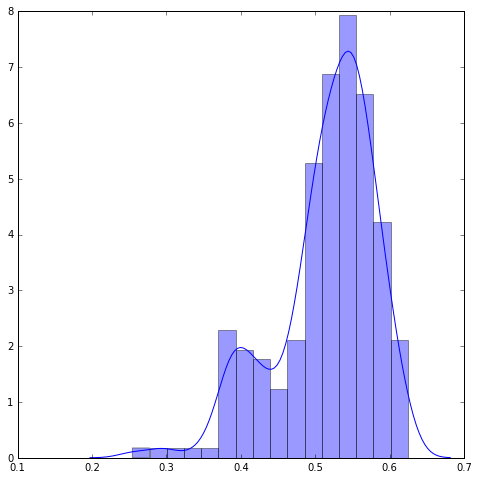

In [17]:
sns.distplot(model_A.predict_proba(X)[:,list(model_A.classes_).index('2')])

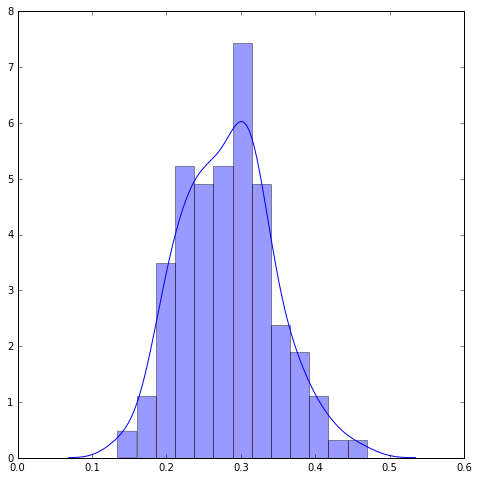

In [18]:
sns.distplot(model_A.predict_proba(X)[:,list(model_A.classes_).index('1')])

In [19]:
rating_counts/sum(rating_counts)

rating
1               0.293878
2               0.506122
3               0.138776
4               0.012245
Fair            0.016327
Satisfactory    0.032653
dtype: float64

The model's predictions basically just match the observed probabilities in the data set. We're not learning anything here.  This model seems to support our hypothesis.

In [20]:
dumb_guess_accuracy = accuracy_score(y_test, ['2']*len(y_test))
print("Dumb Guess Testing Accuracy: %f" % dumb_guess_accuracy)
print("Model Testing Accuracy: %f" % testing_accuracy)

Dumb Guess Testing Accuracy: 0.467742
Model Testing Accuracy: 0.467742


The problem seems to be that our off-the-shelf sentiment analyzer from Google doesn't work well on this data.  Let's try to build our own.